In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.ensemble import BaggingRegressor

from sklearn.metrics import make_scorer
from sklearn.feature_selection import mutual_info_regression

In [2]:
rs = 42
models = [LinearRegression(), 
          KNeighborsRegressor(),
          DecisionTreeRegressor(random_state=rs), 
          RandomForestRegressor(random_state=rs), 
          SVC(random_state=rs)]
sl_festivals = [pd.to_datetime(d) for d in ['2021-10-19', '2021-11-04', '2021-12-25', '2022-01-15']]
sl_holidays = [pd.to_datetime(d) for d in ['2021-10-20', '2021-11-18', '2021-12-18', '2022-01-17', 
                                           '2022-02-04', '2022-02-16']]

Week = {'w1':20, 'w2':21, 'w3':22, 'w4':23}
has_festival = [21]
has_holiday = [23]

In [3]:
def find_week(date, count_from=pd.to_datetime('2021-10-01')):
    return (date - count_from).days//7

def TotalMAPE_score(y_true, y_pred):
    return (sum(abs(y_pred - y_true))/sum(y_true))*100

def UF_MAPE(y_true, y_pred):
    y_diff = y_true - y_pred
    y_uf = y_diff.loc[y_diff > 0]
    return (sum(abs(y_uf))/sum(y_true))*100

def find_buffer(y_true, y_pred, typ):
    y_diff = y_true - y_pred
    y_uf = y_diff.loc[y_diff > 0]
    if y_uf.count() != 0:
        if typ == 'np':
            y_uf = y_uf.loc[y_uf <= np.percentile(y_uf, 60)]
            np_buffer = y_uf.mean()
            return np_buffer
        elif typ == 'op':
            y_uf = y_uf.loc[y_uf <= np.percentile(y_uf, 60)]
            op_buffer = y_uf.mean()
            return op_buffer
    return 0

def make_mi_scores(X, y):
    discrete_features = X.dtypes == int
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=rs)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    plt.figure(dpi=100, figsize=(8, 5))
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    plt.show()
    
def evaluate(models, X_train, X_val, y_train, y_val, typ):
    results = pd.DataFrame({'Model': [], 
                            'VTMAPE_score': [], 'VUMAPE_score': [], 'VBuffer': [], 
                            'TTMAPE_score': [], 'TUMAPE_score': [], 'TBuffer': []})
    for model in models:
        m = model.fit(X_train, y_train)
        y_train_pred = m.predict(X_train)
        y_val_pred = m.predict(X_val)
        new_result = {'Model': model.__class__.__name__, 
                      'VTMAPE_score': TotalMAPE_score(y_val, y_val_pred), 
                      'TTMAPE_score': TotalMAPE_score(y_train, y_train_pred), 
                      'VUMAPE_score': UF_MAPE(y_val, y_val_pred), 
                      'TUMAPE_score': UF_MAPE(y_train, y_train_pred), 
                      'VBuffer': find_buffer(y_val, y_val_pred, typ),
                      'TBuffer': find_buffer(y_train, y_train_pred, typ)}
        results = results.append(new_result, ignore_index=True)
    return results.sort_values(by=['VTMAPE_score', 'VUMAPE_score', 'VBuffer', 'TTMAPE_score', 'TUMAPE_score', 'TBuffer'])

def buffer_crted_evaluate(models, X_train, X_val, y_train, y_val, typ):
    results = pd.DataFrame({'Model': [], 
                            'VTMAPE_score': [], 'VUMAPE_score': [], 'VBuffer': [], 
                            'TTMAPE_score': [], 'TUMAPE_score': [], 'TBuffer': []})
    for model in models:
        m = model.fit(X_train, y_train)
        y_train_pred = m.predict(X_train)
        y_val_pred = m.predict(X_val)
        train_buffer = find_buffer(y_train, y_train_pred, typ)
        val_buffer = find_buffer(y_val, y_val_pred, typ)
        y_train_pred = y_train_pred + train_buffer
        y_val_pred = y_val_pred + val_buffer
        new_result = {'Model': model.__class__.__name__, 
                      'VTMAPE_score': TotalMAPE_score(y_val, y_val_pred), 
                      'TTMAPE_score': TotalMAPE_score(y_train, y_train_pred), 
                      'VUMAPE_score': UF_MAPE(y_val, y_val_pred), 
                      'TUMAPE_score': UF_MAPE(y_train, y_train_pred), 
                      'VBuffer': val_buffer, 
                      'TBuffer': train_buffer}
        results = results.append(new_result, ignore_index=True)
    return results.sort_values(by=['VTMAPE_score', 'VUMAPE_score', 'VBuffer', 'TTMAPE_score', 'TUMAPE_score', 'TBuffer'])

In [4]:
sl_festivals_week = [find_week(d) for d in sl_festivals]
sl_holidays_week = [find_week(d) for d in sl_holidays]

sl_festivals_week, sl_holidays_week

([2, 4, 12, 15], [2, 6, 11, 15, 18, 19])

In [5]:
train_data_path = './data/train_data.csv'
promotion_data_path = './data/promotion_data.csv'
val_data_path = './data/validation_data.csv'
test_data_path = './data/test_data.csv'

In [6]:
train_df = pd.read_csv(train_data_path)
promotion_df = pd.read_csv(promotion_data_path)
val_df = pd.read_csv(val_data_path)
test_df = pd.read_csv(test_data_path)

In [7]:
print(train_df.shape)
train_df.head()

(20651, 4)


,CategoryCode,ItemCode,DateID,DailySales
0,category_2,1071115,12/19/2021,1
1,category_4,210652,2/13/2022,1
2,category_2,877624,12/19/2021,1
3,category_1,371104,12/19/2021,3
4,category_1,1090294,12/19/2021,3


In [8]:
print(promotion_df.shape)
promotion_df.head()

(314, 6)


,ItemCode,PromotionStartDate,PromotionEndDate,DiscountValue,DiscountType,SellingPrice
0,379249,12/3/2021,12/9/2021,10,Percentage,70
1,1066570,11/19/2021,11/25/2021,15,Percentage,45
2,124954,10/29/2021,11/4/2021,15,Percentage,210
3,35530,10/22/2021,10/28/2021,15,Percentage,60
4,1013335,1/21/2022,1/27/2022,10,Percentage,210


In [9]:
print(val_df.shape)
val_df.head()

(373, 5)


,CategoryCode,ItemCode,Week,OnPromo,WeeklySales
0,category_2,1006090,w1,0,9
1,category_2,1105009,w1,0,15
2,category_2,1098502,w3,0,7
3,category_1,1081321,w3,0,25
4,category_4,1074823,w1,0,24


In [10]:
print(test_df.shape)
test_df.head()

(377, 5)


,CategoryCode,ItemCode,Week,OnPromo,PredictedSales
0,category_1,1048975,w4,0,NaN
1,category_1,43738,w4,0,NaN
2,category_2,1044502,w1,0,NaN
3,category_2,913561,w4,0,NaN
4,category_2,216151,w4,0,NaN


In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20651 entries, 0 to 20650
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CategoryCode  20651 non-null  object
 1   ItemCode      20651 non-null  int64 
 2   DateID        20651 non-null  object
 3   DailySales    20651 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 645.5+ KB


<AxesSubplot:xlabel='CategoryCode', ylabel='count'>

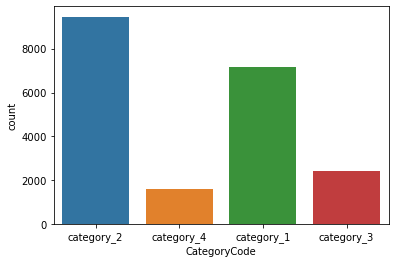

In [12]:
sns.countplot(x=train_df.CategoryCode)

In [13]:
train_df.DailySales.describe()

count    20651.000000
mean         7.295482
std         14.471197
min          1.000000
25%          2.000000
50%          3.000000
75%          7.000000
max        434.000000
Name: DailySales, dtype: float64

In [14]:
promotion_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314 entries, 0 to 313
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ItemCode            314 non-null    int64 
 1   PromotionStartDate  314 non-null    object
 2   PromotionEndDate    314 non-null    object
 3   DiscountValue       314 non-null    int64 
 4   DiscountType        314 non-null    object
 5   SellingPrice        314 non-null    int64 
dtypes: int64(3), object(3)
memory usage: 14.8+ KB


In [15]:
promotion_df.describe().T

,count,mean,std,min,25%,50%,75%,max
ItemCode,314.0,584578.353503,469041.320382,7666.0,64978.0,755584.0,1071119.5,1101571.0
DiscountValue,314.0,12.786624,5.343386,5.0,10.0,10.0,15.0,30.0
SellingPrice,314.0,125.923567,85.447332,40.0,70.0,75.0,190.0,370.0


In [16]:
train_df.DateID = pd.to_datetime(train_df.DateID)
promotion_df.PromotionStartDate = pd.to_datetime(promotion_df.PromotionStartDate)
promotion_df.PromotionEndDate = pd.to_datetime(promotion_df.PromotionEndDate)
promotion_df['Dif'] = promotion_df.PromotionEndDate - promotion_df.PromotionStartDate
promotion_df.Dif.value_counts()

6 days    302
9 days     12
Name: Dif, dtype: int64

In [17]:
def add_week(row):
    row.PromotionStartWeek = find_week(row['PromotionStartDate'])
    row.PromotionEndWeek = find_week(row['PromotionEndDate'])
    return row

promotion_df['PromotionStartWeek'] = np.nan
promotion_df['PromotionEndWeek'] = np.nan
w_added_promotion = promotion_df.apply(add_week, axis='columns')
w_added_promotion.head()

,ItemCode,PromotionStartDate,PromotionEndDate,DiscountValue,DiscountType,SellingPrice,Dif,PromotionStartWeek,PromotionEndWeek
0,379249,2021-12-03,2021-12-09,10,Percentage,70,6 days,9,9
1,1066570,2021-11-19,2021-11-25,15,Percentage,45,6 days,7,7
2,124954,2021-10-29,2021-11-04,15,Percentage,210,6 days,4,4
3,35530,2021-10-22,2021-10-28,15,Percentage,60,6 days,3,3
4,1013335,2022-01-21,2022-01-27,10,Percentage,210,6 days,16,16


In [18]:
w_added_promotion.ItemCode.value_counts()

1066570    14
1085749    13
1048975    13
17287      13
379249     12
           ..
815101      1
1090276     1
687616      1
903976      1
1071124     1
Name: ItemCode, Length: 66, dtype: int64

In [19]:
can_has_promo_ic = w_added_promotion.ItemCode.unique()
can_has_promo_ic

array([ 379249, 1066570,  124954,   35530, 1013335,   24136, 1085749,
       1081069,   17287,  117610,   64978,  132334,   23200,    7666,
         23569,  745945, 1006099, 1090258, 1075651,  130993,  999403,
       1048975, 1101571,   50785, 1082743,   40759, 1101562,   65788,
        836125,  755584,   37861,  872260, 1090024,  132028,  172033,
         17296,   59749,   30877,  119554,  399220,   87559,  836152,
        815101,  267478, 1006090, 1010068, 1076938, 1077118, 1006009,
       1074823, 1064473, 1006108,  903976, 1090240, 1101553,  753613,
        687616, 1090276, 1076929,   20824,   39436, 1064572,   41830,
       1071106, 1090249, 1071124])

In [20]:
promotion = w_added_promotion.drop(columns=['PromotionStartDate', 'PromotionEndDate', 'Dif'])

s_promotion = promotion.drop(columns=['PromotionEndWeek'])
e_promotion = promotion.loc[promotion.PromotionStartWeek != promotion.PromotionEndWeek].drop(columns=['PromotionStartWeek'])

s_promotion.rename(columns={'PromotionStartWeek': 'Week'}, inplace=True)
e_promotion.rename(columns={'PromotionEndWeek': 'Week'}, inplace=True)

promotion = s_promotion.append(e_promotion, ignore_index=True)
promotion.sort_values(by=['Week'])

,ItemCode,DiscountValue,DiscountType,SellingPrice,Week
162,1066570,15,Percentage,45,0
149,39436,25,Percentage,70,0
151,132334,10,Percentage,190,0
100,903976,15,Percentage,80,0
85,1006009,10,Percentage,70,0
...,...,...,...,...,...
311,1076938,10,Percentage,80,23
247,7666,20,Percentage,45,23
27,999403,10,Percentage,260,23
187,59749,15,Percentage,200,23


In [21]:
def add_discount_money(row):
    if row.DiscountType == 'Amount':
        row.DiscountMoney = row.DiscountValue
    elif row.DiscountType == 'Percentage':
        row.DiscountMoney = (row.DiscountValue/100) * row.SellingPrice
    return row

promotion['DiscountMoney'] = np.nan
promotion = promotion.apply(add_discount_money, axis='columns')
promotion.head()

,ItemCode,DiscountValue,DiscountType,SellingPrice,Week,DiscountMoney
0,379249,10,Percentage,70,9,7.00
1,1066570,15,Percentage,45,7,6.75
2,124954,15,Percentage,210,4,31.50
3,35530,15,Percentage,60,3,9.00
4,1013335,10,Percentage,210,16,21.00


In [22]:
promotion.drop(columns=['DiscountType', 'DiscountValue'], inplace=True)

In [23]:
def add_discount_percentage(row):
    row.DiscountPercentage = (row.DiscountMoney/row.SellingPrice) * 100
    return row

promotion['DiscountPercentage'] = np.nan
promotion = promotion.apply(add_discount_percentage, axis='columns')
promotion.head()

,ItemCode,SellingPrice,Week,DiscountMoney,DiscountPercentage
0,379249.0,70.0,9.0,7.00,10.0
1,1066570.0,45.0,7.0,6.75,15.0
2,124954.0,210.0,4.0,31.50,15.0
3,35530.0,60.0,3.0,9.00,15.0
4,1013335.0,210.0,16.0,21.00,10.0


In [24]:
promotion.drop(columns=['SellingPrice', 'DiscountMoney'], inplace=True)

In [25]:
def add_week(row):
    row.Week = find_week(row['DateID'])
    return row

train_df['Week'] = np.nan
w_added_train = train_df.apply(add_week, axis='columns')
w_added_train.sort_values('DateID')

,CategoryCode,ItemCode,DateID,DailySales,Week
6447,category_2,117610,2021-10-01,1,0
6354,category_4,245581,2021-10-01,6,0
6355,category_2,1090258,2021-10-01,2,0
6356,category_2,39436,2021-10-01,60,0
6357,category_3,1090024,2021-10-01,4,0
...,...,...,...,...,...
18195,category_3,16936,2022-02-17,2,19
18199,category_1,371239,2022-02-17,2,19
18200,category_1,1030948,2022-02-17,2,19
18182,category_1,52099,2022-02-17,2,19


In [26]:
groupby_ciw_train = pd.DataFrame(w_added_train.groupby(['CategoryCode', 'ItemCode', 'Week']).DailySales.sum())
groupby_ciw_train.rename(columns={'DailySales': 'WeeklySales'}, inplace=True)
groupby_ciw_train.reset_index(inplace=True)
groupby_ciw_train.head()

,CategoryCode,ItemCode,Week,WeeklySales
0,category_1,3418,0,45
1,category_1,3418,1,50
2,category_1,3418,2,49
3,category_1,3418,3,38
4,category_1,3418,4,53


In [27]:
def add_on_promo(row):
    if row.Week in promotion.loc[promotion.ItemCode == row.ItemCode, 'Week'].values:
        row.OnPromo = 1
    return row

groupby_ciw_train['OnPromo'] = 0
train = groupby_ciw_train.apply(add_on_promo, axis='columns')
train.head()

,CategoryCode,ItemCode,Week,WeeklySales,OnPromo
0,category_1,3418,0,45,0
1,category_1,3418,1,50,0
2,category_1,3418,2,49,0
3,category_1,3418,3,38,0
4,category_1,3418,4,53,0


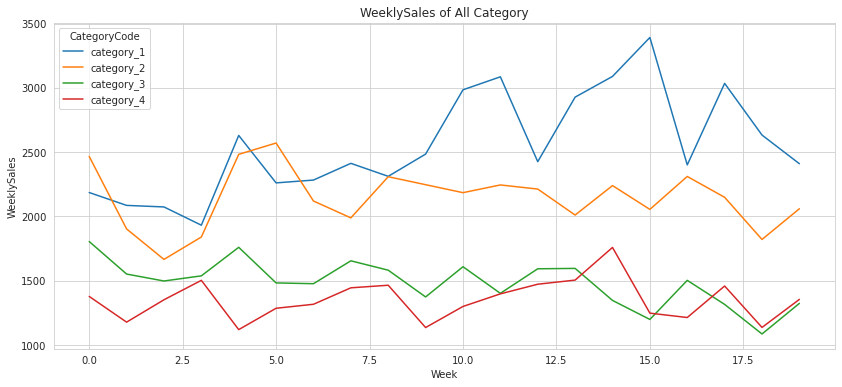

In [28]:
data = train.copy()
data = pd.DataFrame(data.groupby(['CategoryCode', 'Week']).WeeklySales.sum())

sns.set_style("whitegrid")
plt.figure(figsize=(14,6))
plt.title("WeeklySales of All Category")
sns.lineplot(data=data.loc[pd.IndexSlice[:,:],:], x='Week', y='WeeklySales', hue='CategoryCode')
plt.show()

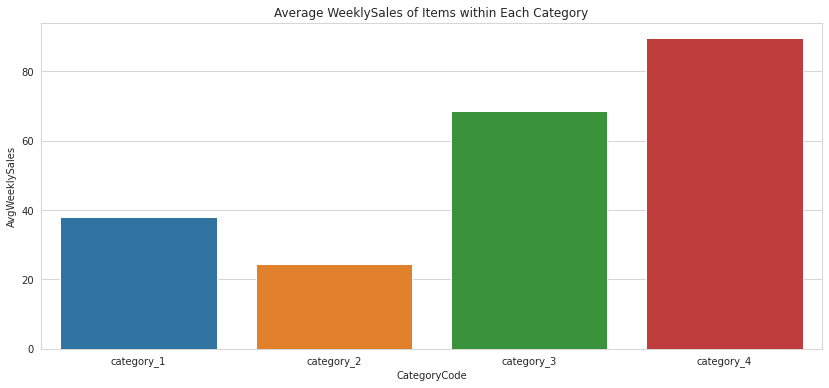

In [29]:
data = train.copy()
data = pd.DataFrame(data.groupby(['CategoryCode']).WeeklySales.mean())
data.rename(columns={'WeeklySales': 'AvgWeeklySales'}, inplace=True)

plt.figure(figsize=(14,6))
plt.title("Average WeeklySales of Items within Each Category")
sns.barplot(data=data.reset_index(), x='CategoryCode', y='AvgWeeklySales')
plt.show()

In [30]:
encoder= ce.OrdinalEncoder(cols=['CategoryCode'],return_df=True,
                           mapping=[{
                               'col':'CategoryCode',
                               'mapping':{'category_1':2,'category_2':1,'category_3':3,'category_4':4}
                                }])
enocoded_train = encoder.fit_transform(train)

/home/kajanan/ProgramFiles/anaconda3/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [31]:
cols = ['HasFestival', 'HasHoliday']

def add_special_day(row):
    if row.Week in sl_festivals_week:
        row.HasFestival = 1
    if row.Week in sl_holidays_week:
        row.HasHoliday = 1
    return row

enocoded_train[cols] = 0
enocoded_train = enocoded_train.apply(add_special_day, axis='columns')
enocoded_train.head()

,CategoryCode,ItemCode,Week,WeeklySales,OnPromo,HasFestival,HasHoliday
0,2,3418,0,45,0,0,0
1,2,3418,1,50,0,0,0
2,2,3418,2,49,0,1,1
3,2,3418,3,38,0,0,0
4,2,3418,4,53,0,1,0


In [32]:
on_promo_enocoded_train = enocoded_train.loc[enocoded_train.OnPromo == 1].drop(columns=['OnPromo'])
not_promo_enocoded_train = enocoded_train.loc[enocoded_train.OnPromo == 0].drop(columns=['OnPromo'])

cols = ['DiscountPercentage']

def add_promo_details(row):
    for col in cols:
        row[col] = promotion.loc[(promotion.ItemCode == row.ItemCode) & 
                                  (promotion.Week == row.Week), col]
    return row

on_promo_enocoded_train[cols] = np.nan
on_promo_enocoded_train = on_promo_enocoded_train.apply(add_promo_details, axis='columns')
on_promo_enocoded_train.head()

,CategoryCode,ItemCode,Week,WeeklySales,HasFestival,HasHoliday,DiscountPercentage
44,2.0,17287.0,4.0,22.0,1.0,0.0,10.0
45,2.0,17287.0,5.0,15.0,0.0,0.0,10.0
46,2.0,17287.0,6.0,13.0,0.0,1.0,10.0
47,2.0,17287.0,7.0,15.0,0.0,0.0,10.0
48,2.0,17287.0,8.0,29.0,0.0,0.0,10.0


In [33]:
on_promo_X_train = on_promo_enocoded_train.drop(columns=['WeeklySales'])
on_promo_y_train = on_promo_enocoded_train.WeeklySales

not_promo_X_train = not_promo_enocoded_train.drop(columns=['WeeklySales'])
not_promo_y_train = not_promo_enocoded_train.WeeklySales

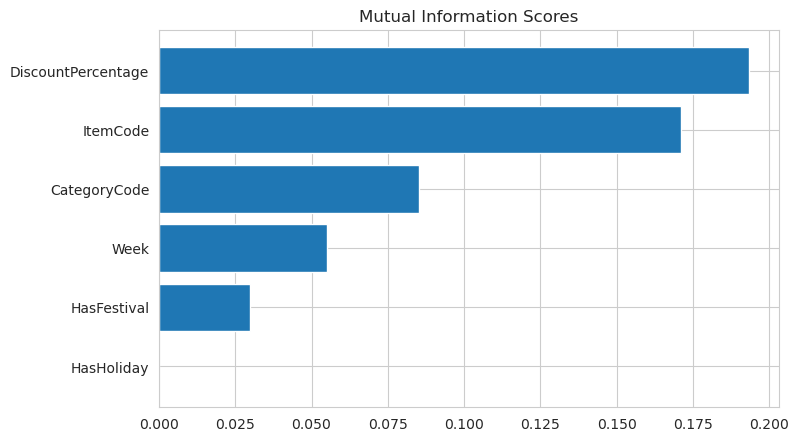

In [34]:
mi_score = make_mi_scores(on_promo_X_train, on_promo_y_train)
plot_mi_scores(mi_score)

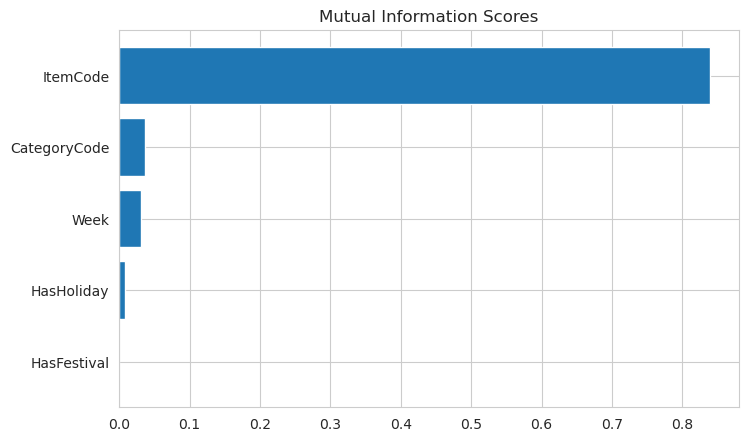

In [35]:
mi_score = make_mi_scores(not_promo_X_train, not_promo_y_train)
plot_mi_scores(mi_score)

## Val

In [36]:
def add_week(row):
    row.Week = Week[row['Week']]
    return row

w_added_val = val_df.apply(add_week, axis='columns')
w_added_val.head()

,CategoryCode,ItemCode,Week,OnPromo,WeeklySales
0,category_2,1006090,20,0,9
1,category_2,1105009,20,0,15
2,category_2,1098502,22,0,7
3,category_1,1081321,22,0,25
4,category_4,1074823,20,0,24


In [37]:
enocoded_val = encoder.transform(w_added_val)

cols = ['HasFestival', 'HasHoliday']

def add_special_day(row):
    if row.Week in has_festival:
        row.HasFestival = 1
    if row.Week in has_holiday:
        row.HasHoliday = 1
    return row

enocoded_val[cols] = 0
enocoded_val = enocoded_val.apply(add_special_day, axis='columns')

on_promo_enocoded_val = enocoded_val.loc[enocoded_val.OnPromo == 1].drop(columns=['OnPromo'])
not_promo_enocoded_val = enocoded_val.loc[enocoded_val.OnPromo == 0].drop(columns=['OnPromo'])

cols = ['DiscountPercentage']

def add_promo_details(row):
    for col in cols:
        row[col] = promotion.loc[(promotion.ItemCode == row.ItemCode) & 
                                  (promotion.Week == row.Week), col]
    return row

on_promo_enocoded_val[cols] = np.nan
on_promo_enocoded_val = on_promo_enocoded_val.apply(add_promo_details, axis='columns')

on_promo_X_val = on_promo_enocoded_val.drop(columns=['WeeklySales'])
on_promo_y_val = on_promo_enocoded_val.WeeklySales

not_promo_X_val = not_promo_enocoded_val.drop(columns=['WeeklySales'])
not_promo_y_val = not_promo_enocoded_val.WeeklySales

In [38]:
evaluate(models, not_promo_X_train, not_promo_X_val, not_promo_y_train, not_promo_y_val, 'np')

,Model,VTMAPE_score,VUMAPE_score,VBuffer,TTMAPE_score,TUMAPE_score,TBuffer
1,KNeighborsRegressor,35.616253,23.828105,5.187097,24.318959,11.778924,2.635244
3,RandomForestRegressor,40.069091,25.583789,4.763651,11.582304,5.576284,1.154840
2,DecisionTreeRegressor,44.560637,26.996514,6.135593,0.000000,0.000000,0.000000
0,LinearRegression,79.443903,50.738447,14.991065,88.240930,44.120465,7.822486
4,SVC,83.830186,82.591957,11.632530,78.422886,75.254665,8.768087


In [39]:
buffer_crted_evaluate(models, not_promo_X_train, not_promo_X_val, not_promo_y_train, not_promo_y_val, 'np')

,Model,VTMAPE_score,VUMAPE_score,VBuffer,TTMAPE_score,TUMAPE_score,TBuffer
1,KNeighborsRegressor,36.073213,19.320434,5.187097,26.182092,9.111349,2.635244
3,RandomForestRegressor,40.276284,21.337868,4.763651,12.354389,4.385078,1.154840
2,DecisionTreeRegressor,45.390591,21.809303,6.135593,0.000000,0.000000,0.000000
4,SVC,78.843076,69.477159,11.632530,75.012142,61.574090,8.768087
0,LinearRegression,90.745051,42.701221,14.991065,96.657681,37.645112,7.822486


In [40]:
evaluate(models, on_promo_X_train, on_promo_X_val, on_promo_y_train, on_promo_y_val, 'op')

,Model,VTMAPE_score,VUMAPE_score,VBuffer,TTMAPE_score,TUMAPE_score,TBuffer
1,KNeighborsRegressor,40.743945,18.235294,8.800000,34.439911,19.102303,7.626667
3,RandomForestRegressor,50.701557,20.140138,10.674000,16.789177,8.289517,3.773433
4,SVC,62.283737,57.352941,16.916667,74.011464,70.528515,19.066116
0,LinearRegression,68.337176,43.211740,14.628347,64.492795,32.246398,16.758953
2,DecisionTreeRegressor,73.615917,24.913495,9.333333,0.000000,0.000000,0.000000


In [41]:
buffer_crted_evaluate(models, on_promo_X_train, on_promo_X_val, on_promo_y_train, on_promo_y_val, 'op')

,Model,VTMAPE_score,VUMAPE_score,VBuffer,TTMAPE_score,TUMAPE_score,TBuffer
1,KNeighborsRegressor,46.245675,12.612457,8.800000,37.247126,15.319214,7.626667
4,SVC,54.152249,37.190023,16.916667,70.149897,55.631365,19.066116
3,RandomForestRegressor,59.063841,14.164360,10.674000,18.662134,6.659783,3.773433
0,LinearRegression,66.715764,28.481327,14.628347,74.253054,25.729201,16.758953
2,DecisionTreeRegressor,77.479815,17.964245,9.333333,0.000000,0.000000,0.000000


In [42]:
K = [3, 5]
P = [1, 2]
W = ['uniform','distance']

## not_promo_model

In [43]:
for k in K:
    for p in P:
        for w in W:
            print('\nk =', k, ', p =', p, ', w =', w, '\n')
            b_models = [KNeighborsRegressor(n_neighbors=k, p=p, weights=w)]
            print(evaluate(b_models, not_promo_X_train, not_promo_X_val, not_promo_y_train, not_promo_y_val, 'np')[['VTMAPE_score', 'VUMAPE_score']])


k = 3 , p = 1 , w = uniform 

   VTMAPE_score  VUMAPE_score
0     38.346947     27.508107

k = 3 , p = 1 , w = distance 

   VTMAPE_score  VUMAPE_score
0      38.29953     27.406957

k = 3 , p = 2 , w = uniform 

   VTMAPE_score  VUMAPE_score
0     38.275844     27.577476

k = 3 , p = 2 , w = distance 

   VTMAPE_score  VUMAPE_score
0      38.16062     27.409441

k = 5 , p = 1 , w = uniform 

   VTMAPE_score  VUMAPE_score
0     35.538213     23.782321

k = 5 , p = 1 , w = distance 

   VTMAPE_score  VUMAPE_score
0     36.114803     24.583893

k = 5 , p = 2 , w = uniform 

   VTMAPE_score  VUMAPE_score
0     35.616253     23.828105

k = 5 , p = 2 , w = distance 

   VTMAPE_score  VUMAPE_score
0     35.872134     24.488348


## on_promo_model

In [44]:
for k in K:
    for p in P:
        for w in W:
            print('\nk =', k, ', p =', p, ', w =', w)
            b_models = [KNeighborsRegressor(n_neighbors=k, p=p, weights=w)]
            print(evaluate(b_models, on_promo_X_train, on_promo_X_val, on_promo_y_train, on_promo_y_val, 'op')[['VTMAPE_score', 'VUMAPE_score']])


k = 3 , p = 1 , w = uniform
   VTMAPE_score  VUMAPE_score
0      36.44752     18.310265

k = 3 , p = 1 , w = distance
   VTMAPE_score  VUMAPE_score
0     33.998739     16.392866

k = 3 , p = 2 , w = uniform
   VTMAPE_score  VUMAPE_score
0     39.705882     20.184544

k = 3 , p = 2 , w = distance
   VTMAPE_score  VUMAPE_score
0     37.598059     17.892306

k = 5 , p = 1 , w = uniform
   VTMAPE_score  VUMAPE_score
0     39.550173     17.024221

k = 5 , p = 1 , w = distance
   VTMAPE_score  VUMAPE_score
0     36.402968     13.678847

k = 5 , p = 2 , w = uniform
   VTMAPE_score  VUMAPE_score
0     40.743945     18.235294

k = 5 , p = 2 , w = distance
   VTMAPE_score  VUMAPE_score
0     36.073012     14.567504


In [45]:
not_promo_model = KNeighborsRegressor(n_neighbors=5, p=1)
on_promo_model = KNeighborsRegressor(n_neighbors=3, p=1, weights='distance')

In [46]:
buffer_crted_evaluate([not_promo_model], not_promo_X_train, not_promo_X_val, not_promo_y_train, not_promo_y_val, 'np')

,Model,VTMAPE_score,VUMAPE_score,VBuffer,TTMAPE_score,TUMAPE_score,TBuffer
0,KNeighborsRegressor,35.838639,19.578036,4.769106,26.08534,9.143135,2.598954


In [47]:
buffer_crted_evaluate([on_promo_model], on_promo_X_train, on_promo_X_val, on_promo_y_train, on_promo_y_val, 'op')

,Model,VTMAPE_score,VUMAPE_score,VBuffer,TTMAPE_score,TUMAPE_score,TBuffer
0,KNeighborsRegressor,35.536172,13.76289,3.571717,0.0,0.0,0.0


In [48]:
not_promo_model_bag = BaggingRegressor(not_promo_model, random_state=rs)
on_promo_model_bag = BaggingRegressor(on_promo_model, random_state=rs)

In [49]:
buffer_crted_evaluate([not_promo_model_bag], not_promo_X_train, not_promo_X_val, not_promo_y_train, not_promo_y_val, 'np')

,Model,VTMAPE_score,VUMAPE_score,VBuffer,TTMAPE_score,TUMAPE_score,TBuffer
0,BaggingRegressor,37.535449,19.886785,4.833934,25.607946,9.186199,2.456514


In [50]:
buffer_crted_evaluate([on_promo_model_bag], on_promo_X_train, on_promo_X_val, on_promo_y_train, on_promo_y_val, 'op')

,Model,VTMAPE_score,VUMAPE_score,VBuffer,TTMAPE_score,TUMAPE_score,TBuffer
0,BaggingRegressor,29.913348,10.882417,2.311066,15.932673,6.69646,2.846339


In [51]:
np_buffer, op_buffer = 4.769106, 2.311066

In [52]:
not_promo_model = KNeighborsRegressor(p=1)
on_promo_model = BaggingRegressor(KNeighborsRegressor(n_neighbors=3, p=1, weights='distance'), random_state=rs)

model = {'not_promo_model': not_promo_model, 'on_promo_model': on_promo_model}

In [53]:
model['not_promo_model'].fit(not_promo_X_train, not_promo_y_train)

KNeighborsRegressor(p=1)

In [54]:
model['on_promo_model'].fit(on_promo_X_train, on_promo_y_train)

BaggingRegressor(base_estimator=KNeighborsRegressor(n_neighbors=3, p=1,
                                                    weights='distance'),
                 random_state=42)

## Test

In [55]:
print(test_df.shape)
test_df.tail()

(377, 5)


,CategoryCode,ItemCode,Week,OnPromo,PredictedSales
372,category_2,20824,w3,0,NaN
373,category_2,130993,w3,1,NaN
374,category_1,35449,w4,0,NaN
375,category_2,1010068,w1,0,NaN
376,category_2,32245,w1,0,NaN


In [56]:
def add_week(row):
    row.Week = Week[row['Week']]
    return row

w_added_test = test_df.apply(add_week, axis='columns')
w_added_test.tail()

,CategoryCode,ItemCode,Week,OnPromo,PredictedSales
372,category_2,20824,22,0,NaN
373,category_2,130993,22,1,NaN
374,category_1,35449,23,0,NaN
375,category_2,1010068,20,0,NaN
376,category_2,32245,20,0,NaN


In [57]:
enocoded_test = encoder.transform(w_added_test)

cols = ['HasFestival', 'HasHoliday']

def add_special_day(row):
    if row.Week in has_festival:
        row.HasFestival = 1
    if row.Week in has_holiday:
        row.HasHoliday = 1
    return row

enocoded_test[cols] = 0
enocoded_test = enocoded_test.apply(add_special_day, axis='columns')
enocoded_test

on_promo_enocoded_test = enocoded_test.loc[enocoded_test.OnPromo == 1].drop(columns=['OnPromo'])
not_promo_enocoded_test = enocoded_test.loc[enocoded_test.OnPromo == 0].drop(columns=['OnPromo'])

cols = ['DiscountPercentage']

def add_promo_details(row):
    for col in cols:
        row[col] = promotion.loc[(promotion.ItemCode == row.ItemCode) & 
                                  (promotion.Week == row.Week), col]
    return row

on_promo_enocoded_test[cols] = np.nan
on_promo_enocoded_test = on_promo_enocoded_test.apply(add_promo_details, axis='columns')

on_promo_X_test = on_promo_enocoded_test.drop(columns=['PredictedSales'])
on_promo_y_test = pd.DataFrame(on_promo_enocoded_test.PredictedSales)

not_promo_X_test = not_promo_enocoded_test.drop(columns=['PredictedSales'])
not_promo_y_test = pd.DataFrame(not_promo_enocoded_test.PredictedSales)

In [58]:
not_promo_y_test['PredictedSales'] = model['not_promo_model'].predict(not_promo_X_test)
not_promo_y_test.tail()

,PredictedSales
371,18.2
372,127.0
374,17.6
375,9.0
376,38.6


In [59]:
not_promo_y_test['PredictedSales'] = not_promo_y_test['PredictedSales'] + np_buffer
not_promo_y_test.tail()

,PredictedSales
371,22.969106
372,131.769106
374,22.369106
375,13.769106
376,43.369106


In [60]:
on_promo_y_test['PredictedSales'] = model['on_promo_model'].predict(on_promo_X_test)
on_promo_y_test.tail()

,PredictedSales
289,35.306615
295,64.051319
336,51.402515
363,60.779956
373,59.906208


In [61]:
on_promo_y_test['PredictedSales'] = on_promo_y_test['PredictedSales'] + op_buffer
on_promo_y_test.tail()

,PredictedSales
289,37.617681
295,66.362385
336,53.713581
363,63.091022
373,62.217274


In [62]:
submission = test_df.copy()
submission['PredictedSales'] = not_promo_y_test.append(on_promo_y_test).sort_index()
submission.tail()

,CategoryCode,ItemCode,Week,OnPromo,PredictedSales
372,category_2,20824,w3,0,131.769106
373,category_2,130993,w3,1,62.217274
374,category_1,35449,w4,0,22.369106
375,category_2,1010068,w1,0,13.769106
376,category_2,32245,w1,0,43.369106


In [63]:
submission.to_csv('./submission/DECISION-MAKERS-test-predicted.csv', index=False)